# Koopman Operator Using Pykoopman

In [1]:
%matplotlib inline
import pykoopman as pk
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from scipy.spatial.transform import Rotation as R
import scipy.io
from scipy.integrate import odeint


In [2]:
def get_odometry(data, angle, vx, vy, vz, wx, wy, wz, vel_control, steer_control, samples_i, samples_f):
    # Get size of the data
    i, j = data.shape
    # Init empty values
    x = np.zeros((1, j), dtype = np.double)
    y = np.zeros((1, j), dtype = np.double)
    z = np.zeros((1, j), dtype = np.double)
    quatenions = np.zeros((4, j), dtype = np.double)
    orientation_aux = np.zeros((3, j), dtype = np.double)

    for k in range(0, j):

        # Get Position
        x[:, k] = data[0, k]
        y[:, k] = data[1, k]
        z[:, k] = 0

        # Get quaternion
        quatenions[:, k] = [data[2, k], data[3, k], data[4, k], data[5, k]]

        # Get Euler Angles
        aux =  quatenions[:, k]
        r = R.from_quat(aux)
        orientation_aux[:, k] = r.as_euler('xyz', degrees = False)

    # get complete data of the system
    h = np.array([x[0,:], y[0,:], z[0,:],
                quatenions[0, :], quatenions[1, :], quatenions[2, :], quatenions[3, :],
                orientation_aux[0, :], orientation_aux[1, :], orientation_aux[2, :],
                angle[0, :]], dtype =np.double)

    # Get Velocities of the system
    hp = np.array([vx[0, :], vy[0, :], vz[0, :], wx[0, :], wy[0, :], wz[0, :]], dtype = np.double)
    T = np.array([vel_control[0,:], steer_control[0, :]], dtype = np.double)
    return h[:, samples_i:samples_f+1], hp[:, samples_i:samples_f+1], T[:, samples_i:samples_f]

In [3]:
def get_simple_data(h, hp, T):
    ## Position
    x = h[0, :]
    y = h[1, :]
    ## Linear velocities
    vx = hp[0, :]
    vy = hp[1, :]
    vz = hp[2, :]

    ## Get angular velocities
    p = hp[3, :]
    q = hp[4, :]
    r = hp[5, :]

    ## Angular velocities vector
    omega = hp[3:6, :]

    ## Orientacion
    quaternion = h[3:7, :]

    ##euler
    euler = h[7:10, :]

    ## Steer angle =
    alpha = h[10, :]

    ## General states data
    #X = np.array([euler[2,:], omega[2, :], alpha, vx, vy], dtype = np.double)
    #X = np.array([euler[0, :], euler[1, :], euler[2, :], omega[0, :], omega[1, :], omega[2, :], alpha, vx, vy, x, y], dtype = np.double)
    X = np.array([euler[2, :], omega[2, :], alpha, vx, vy, x, y], dtype = np.double)
    ## Control Action


    ## Get the dimension of the Data
    i, j = X.shape

    X1 = X[:, 0:j-1]
    X2 = X[:, 1:j]
    U_ref = T[:, 0:j-1]
    return X1, X2, U_ref

In [4]:
Data = scipy.io.loadmat('blue_data_02.mat')

## Get odometry of the system
data_odom_blue = Data['data_odom_blue']
data_odom_blue = data_odom_blue.T

## Get Control steer angle
steering_control = Data['steering_control']
steering_control = steering_control.T
steering_control = steering_control*(np.pi/180)

## Get Steer angle real
steering_real = Data['steering_real']
steering_real = steering_real.T
steering_real = steering_real*(np.pi/180)

## Get system velocities
vx = Data['vx']
vx = vx.T
vy = Data['vy']
vy = vy.T
vz = Data['vz']
vz = vz.T
wx = Data['wx']
wx = wx.T
wy = Data['wy']
wy = wy.T
wz = Data['wz']
wz = wz.T

## Get desired frontal velocity

vel_control = Data['vel_control']
vel_control = vel_control.T

h1, hp1, T1 = get_odometry(data_odom_blue, steering_real, vx, vy, vz, wx, wy, wz, vel_control, steering_control, 0, 1000)

## Get Data DMD
X1_n_1, X2_n_1, U_n_1 = get_simple_data(h1, hp1, T1)


X1_n = X1_n_1
X2_n = X2_n_1
U_n = U_n_1

n_normal = X1_n.shape[0]

# Koopman Space
X1 = X1_n
X2 = X2_n
U = U_n

n = X1.shape[0]
m = U.shape[0]


# Compute auxiliar timer of the system
## Compute sample time of the system
ts = 0.05
t = np.zeros((U.shape[1]), dtype = np.double)
for k in range(0, U.shape[1]-1):
    t[k+1] = t[k] + ts
print(t.shape)
print(X1.shape)


## Define States of the system
input_features = ["psi", "omega", "alpha", "v_x", "v_y", "x", "y"]

(1000,)
(7, 1000)


### Plot observables variables

In [5]:
def plot_observables(observables, x, t, input_features=None, t_delay=None):
    '''Generate plots of state variables before and after being transformed into new observables.'''
    n_features = x.shape[1]
    if input_features is None:
        input_features = [f'x{i}' for i in range(n_features)]
    if t_delay is None:
        t_delay = t

    # Plot input features (state variables)
    fig, axs = plt.subplots(1, n_features, figsize=(n_features * 5, 3))

    for ax, k, feat_name in zip(axs, range(n_features), input_features):
        ax.plot(t, x[:, k])
        ax.set(xlabel='t', title=feat_name)
    fig.suptitle('Original state variables')
    fig.tight_layout()
    # fig.show()

    # Plot output features
    y = observables.fit_transform(x)

    n_output_features = observables.n_output_features_
    feature_names = observables.get_feature_names(input_features)

    n_rows = (n_output_features // 3) + (n_output_features % 3 > 0)
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, 3 * n_rows), sharex=True)

    for ax, k, feat_name in zip(axs.flatten(), range(n_output_features), feature_names):
        ax.plot(t_delay, y[:, k])
        ax.set(xlabel='t', title=feat_name)

    fig.suptitle('Observables')
    fig.tight_layout()
    # fig.show()
    return

### PLot custom observables of the system

/home/fer/miniconda3/envs/koopman_mpc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/home/fer/miniconda3/envs/koopman_mpc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/home/fer/miniconda3/envs/koopman_mpc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


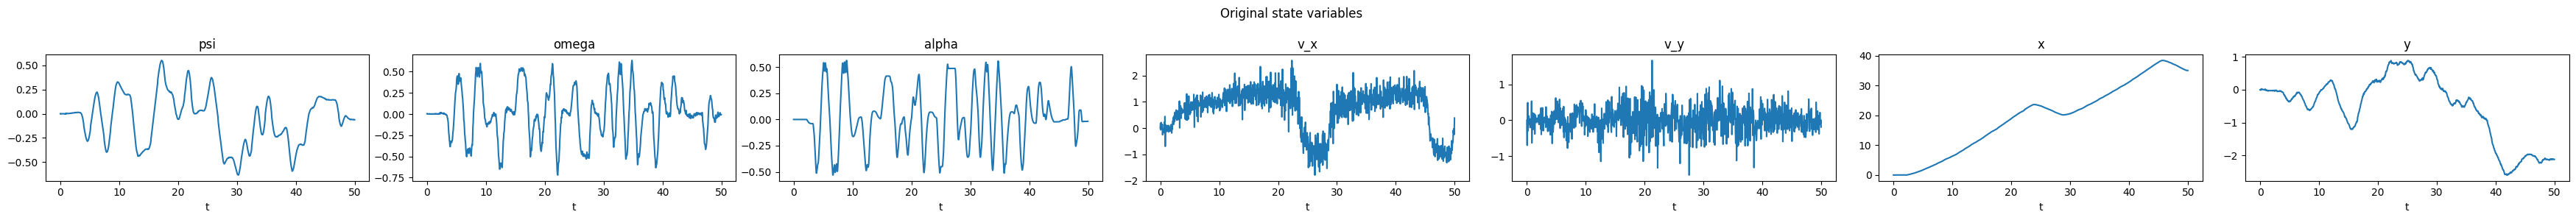

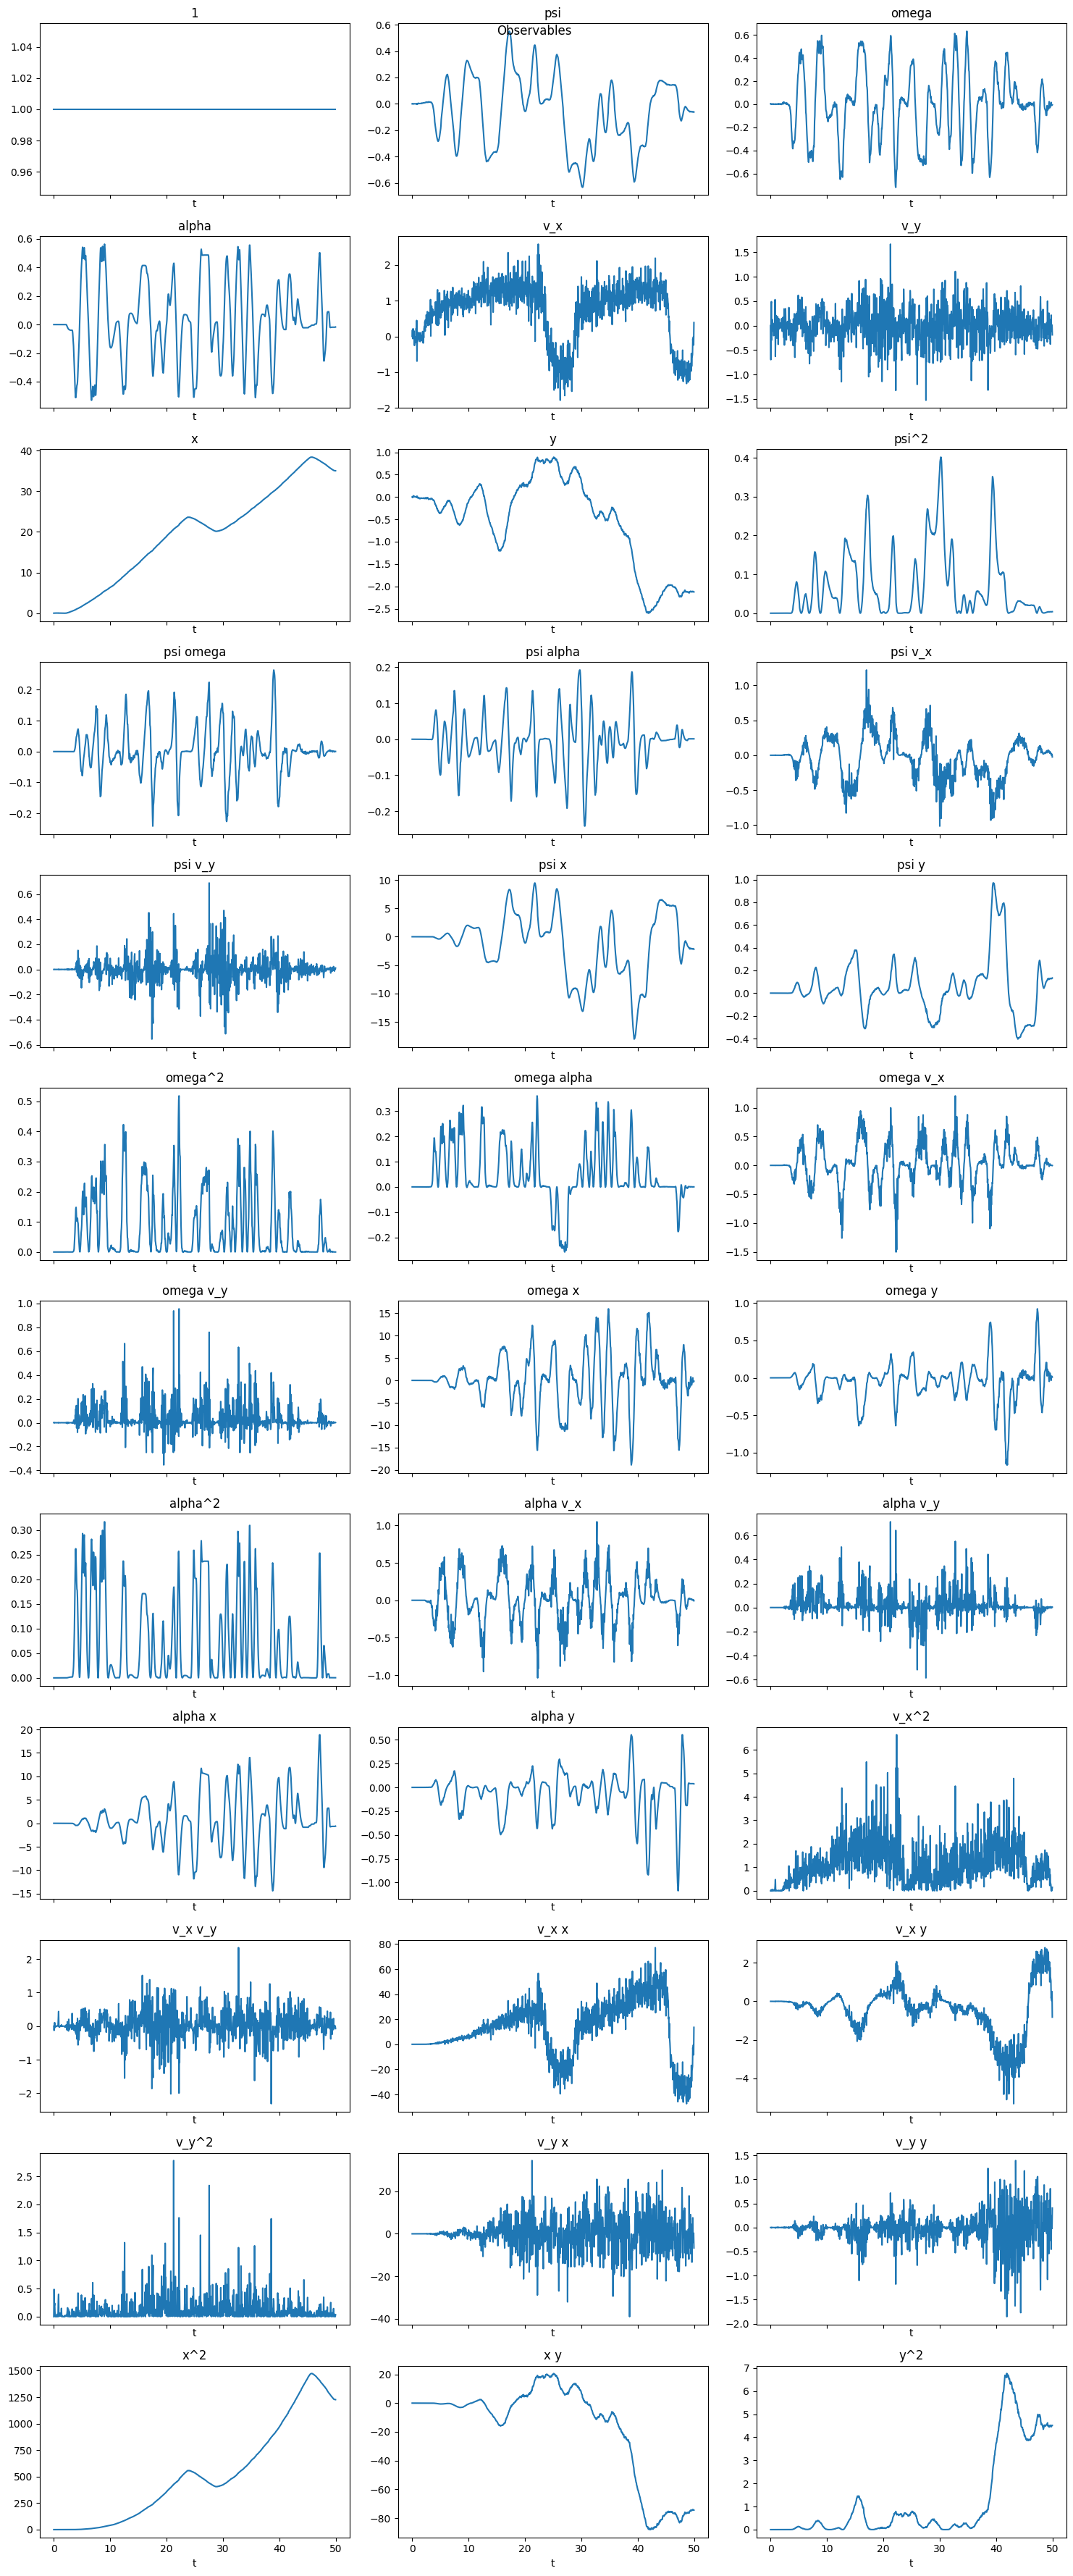

In [6]:
obs = pk.observables.Polynomial(degree=2)
plot_observables(obs, X1.T, t, input_features=input_features)

In [7]:
#delay = 1 # dt
#n_delays = 5
#obs = pk.observables.TimeDelay(delay=delay, n_delays=n_delays)

In [8]:
#t_delay = t[delay * n_delays:]
#plot_observables(obs, X1.T, t, input_features=input_features, t_delay=t_delay)

In [9]:
EDMDc = pk.regression.EDMDc()
model = pk.Koopman(observables=obs, regressor=EDMDc)
model.fit(X1.T, y=X2.T, u=U[:,:].T)

/home/fer/miniconda3/envs/koopman_mpc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/home/fer/miniconda3/envs/koopman_mpc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/home/fer/miniconda3/envs/koopman_mpc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/home/fer/miniconda3/envs/koopman_mpc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=Fut

Koopman(observables=Polynomial(), regressor=EDMDc())

### Prepare Data Koopman

In [23]:
## Validate the system identification using other signals 2,  3
Data = scipy.io.loadmat('blue_data_03.mat')

## Get odometry of the system
data_odom_blue = Data['data_odom_blue']
data_odom_blue = data_odom_blue.T

## Get Control steer angle
steering_control = Data['steering_control']
steering_control = steering_control.T
steering_control = steering_control*(np.pi/180)

## Get Steer angle real
steering_real = Data['steering_real']
steering_real = steering_real.T
steering_real = steering_real*(np.pi/180)

## Get system velocities
vx = Data['vx']
vx = vx.T
vy = Data['vy']
vy = vy.T
vz = Data['vz']
vz = vz.T
wx = Data['wx']
wx = wx.T
wy = Data['wy']
wy = wy.T
wz = Data['wz']
wz = wz.T

## Get desired frontal velocity

vel_control = Data['vel_control']
vel_control = vel_control.T

h1, hp1, T1 = get_odometry(data_odom_blue, steering_real, vx, vy, vz, wx, wy, wz, vel_control, steering_control, 0, 1000)

## Get Data DMD
X1_n_1, X2_n_1, U_n_1 = get_simple_data(h1, hp1, T1)


X1_n = X1_n_1
X2_n = X2_n_1
U_n = U_n_1

n_normal = X1_n.shape[0]

# Koopman Space
X1 = X1_n
X2 = X2_n
U = U_n

x = X1[:, 0].T
u = U.T
Xkoop = model.simulate(x[np.newaxis,:], u[:, np.newaxis], n_steps=X1.shape[1]-1)
Xkoop = np.vstack([x[np.newaxis,:], Xkoop]) # add initial condition to simulated data for comparison below

/home/fer/miniconda3/envs/koopman_mpc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/home/fer/miniconda3/envs/koopman_mpc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/home/fer/miniconda3/envs/koopman_mpc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/home/fer/miniconda3/envs/koopman_mpc/lib/python3.10/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=Fut

ValueError: Input contains NaN.

### Predict using Koopman model

Plot the results

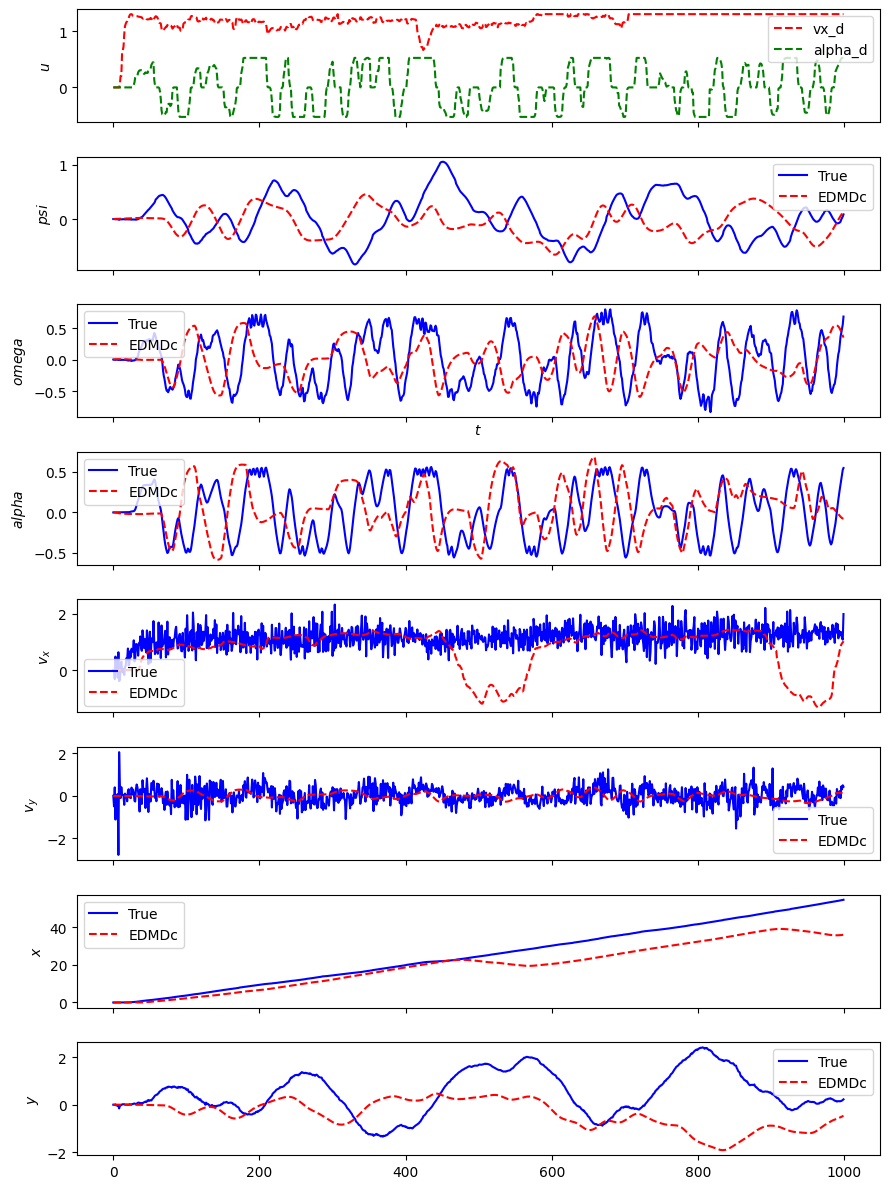

In [24]:
fig, axs = plt.subplots(8, 1, sharex=True, tight_layout=True, figsize=(9, 12))
axs[0].plot(u[:, 0], '--r', label='vx_d')
axs[0].plot(u[:, 1], '--g', label='alpha_d')
axs[0].set(ylabel=r'$u$')
axs[0].legend()

axs[1].plot(X1[0, :], '-', color='b', label='True')
axs[1].plot(Xkoop[:, 0], '--r', label='EDMDc')
axs[1].set(ylabel=r'$psi$')
axs[1].legend()

axs[2].plot(X1[1, :], '-', color='b', label='True')
axs[2].plot(Xkoop[:, 1], '--r', label='EDMDc')
axs[2].set(ylabel=r'$omega$',xlabel=r'$t$')
axs[2].legend()

axs[3].plot(X1[2, :], '-', color='b', label='True')
axs[3].plot(Xkoop[:, 2], '--r', label='EDMDc')
axs[3].set(ylabel=r'$alpha$')
axs[3].legend()

axs[4].plot(X1[3, :], '-', color='b', label='True')
axs[4].plot(Xkoop[:, 3], '--r', label='EDMDc')
axs[4].set(ylabel=r'$v_x$')
axs[4].legend()

axs[5].plot(X1[4, :], '-', color='b', label='True')
axs[5].plot(Xkoop[:, 4], '--r', label='EDMDc')
axs[5].set(ylabel=r'$v_y$')
axs[5].legend()

axs[6].plot(X1[5, :], '-', color='b', label='True')
axs[6].plot(Xkoop[:, 5], '--r', label='EDMDc')
axs[6].set(ylabel=r'$x$')
axs[6].legend()

axs[7].plot(X1[6, :], '-', color='b', label='True')
axs[7].plot(Xkoop[:, 6], '--r', label='EDMDc')
axs[7].set(ylabel=r'$y$')
axs[7].legend()

plt.show()

The lifted system can be easily accessed

$$
z^{+} = A z + B u\\
x = Cz
$$

[-0.36649837+0.j         -0.25955514+0.j         -0.21495383+0.00674348j
 -0.21495383-0.00674348j -0.19498049+0.j         -0.1218119 +0.j
 -0.03893358+0.06325859j -0.03893358-0.06325859j -0.0657829 +0.j
  0.06280654+0.j          0.20890036+0.j          0.28562414+0.j
  0.51042   +0.j          0.63833277+0.j          0.96026052+0.15252433j
  0.96026052-0.15252433j  0.87251915+0.j          0.89121511+0.j
  0.97349458+0.0925444j   0.97349458-0.0925444j   0.96758709+0.08245199j
  0.96758709-0.08245199j  0.93865703+0.02373932j  0.93865703-0.02373932j
  0.98655624+0.06201206j  0.98655624-0.06201206j  0.98703755+0.04672993j
  0.98703755-0.04672993j  0.98558612+0.03350131j  0.98558612-0.03350131j
  0.98997856+0.00889587j  0.98997856-0.00889587j  1.00153145+0.j
  1.00007623+0.0002058j   1.00007623-0.0002058j   1.        +0.j        ]


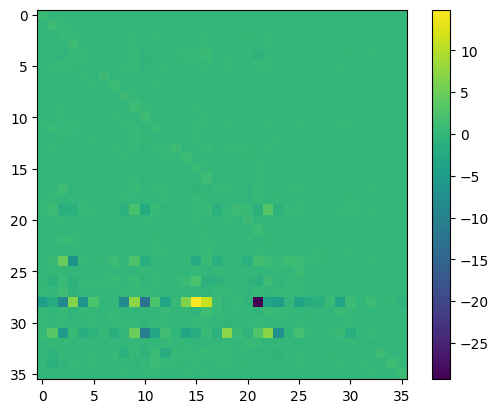

In [20]:
model.A.shape
plt.imshow(model.A)
plt.colorbar()
eig, eiv = np.linalg.eig(model.A)
print(eig)

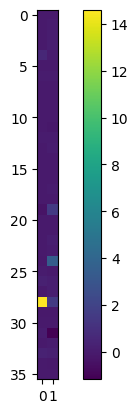

In [13]:
model.B.shape
plt.imshow(model.B)
plt.colorbar()

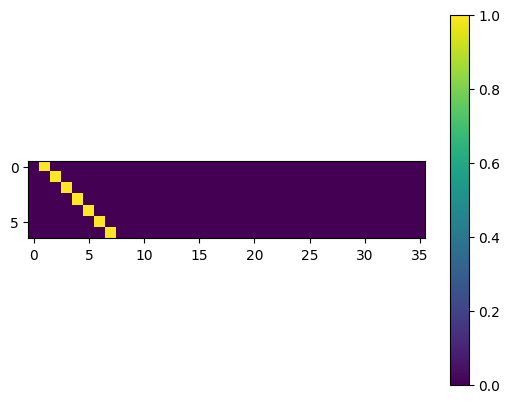

In [14]:
model.C.shape
plt.imshow(model.C)
plt.colorbar()

In [15]:
model.W.shape

(7, 36)